In [ ]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
data = pd.read_csv('rawdata.csv')

# Assuming the first four columns are categorical variables
categorical_data = data.iloc[:, :1]

# The rest are spectral data from 190nm to 1100nm
spectral_data = data.iloc[:, 1:]

In [ ]:
data.head()

,Sample,190,191,192,193,194,195,196,197,198,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,EA,1.540176,1.169678,1.714279,0.380814,1.337555,0.927231,-1.715286,1.185089,0.216888,...,0.028870,0.028824,0.028763,0.028793,0.028687,0.028717,0.028687,0.028610,0.028610,0.028488
1,EAK,1.503937,-0.747436,2.370834,1.196762,-0.389328,0.522797,0.933121,1.739807,2.297928,...,0.061768,0.061630,0.061432,0.061340,0.061203,0.061066,0.060959,0.060822,0.060684,0.060547
2,ES1,0.149231,0.682434,1.917114,0.435059,1.053665,-0.140427,0.243515,-0.153717,0.237427,...,0.129288,0.129211,0.129135,0.129166,0.129105,0.129135,0.129105,0.129089,0.129105,0.128998
3,ES2,2.857132,-0.966858,-0.723679,-0.585190,0.977737,0.835815,0.523834,-0.120895,1.378174,...,0.122360,0.122269,0.122192,0.122147,0.122055,0.122024,0.121902,0.121841,0.121750,0.121582
4,ES3,2.476181,1.321167,-0.088837,-0.453140,-0.229645,0.336670,1.044785,0.358872,1.386948,...,0.017685,0.017578,0.017395,0.017334,0.017242,0.017181,0.017120,0.017044,0.017059,0.016983


In [ ]:
# Install necessary libraries
!pip install numpy pandas matplotlib scipy

In [ ]:
data.shape

(24, 912)

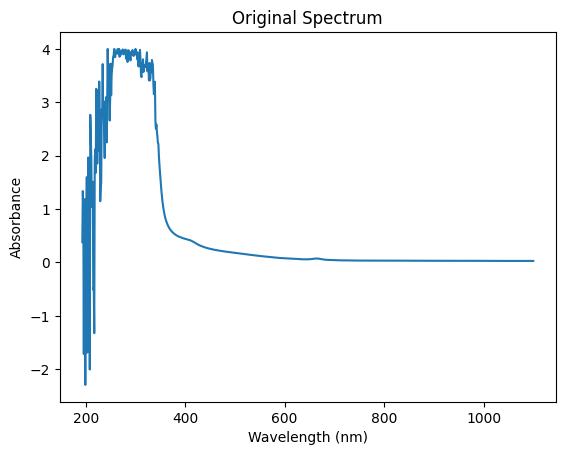

In [ ]:
# Visualize the original spectrum
import matplotlib.pyplot as plt

plt.plot(spectral_data.columns.astype(float), spectral_data.iloc[0, :])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Original Spectrum')
plt.show()

In [ ]:
# Perform adaptive baseline correction
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam=1e6, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    D = lam * D.dot(D.transpose())  # Precompute this term
    w = np.ones(L)
    for i in range(niter):
        W = sparse.diags(w, 0)
        Z = W + D
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [ ]:
# Apply baseline correction to all spectra
corrected_spectra = spectral_data.apply(lambda row: row - baseline_als(row.values), axis=1)
corrected_spectra_df = pd.DataFrame(corrected_spectra, columns=spectral_data.columns)

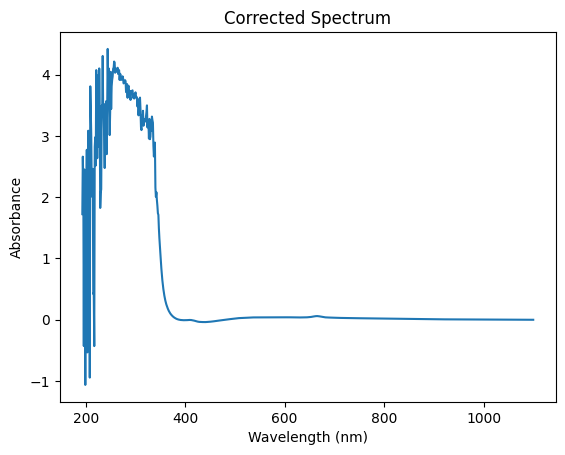

In [ ]:
# Visualize the corrected spectrum
plt.plot(spectral_data.columns.astype(float), corrected_spectra.iloc[0, :])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Corrected Spectrum')
plt.show()

In [ ]:
!pip install numpy scipy pybaselines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 5.2 MB/s eta 0:00:00


Implement adaptive baseline correction (ALS):

In [ ]:
import numpy as np
from pybaselines import Baseline

In [ ]:
# Initialize the Baseline class
baseline = Baseline()

In [ ]:
# Prepare the output DataFrame
corrected_df = data.copy()

In [ ]:
print(data.columns)

Index(['Sample', '190', '191', '192', '193', '194', '195', '196', '197', '198',
       ...
       '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099',
       '1100'],
      dtype='object', length=912)


In [ ]:
# Apply baseline correction for each sample
for sample in data['Sample'].unique():
    sample_data = data[data['Sample'] == sample]

    # Extract the wavelength intensities (assuming first column is 'sample')
    wavelengths = sample_data.columns[1:]
    intensities = sample_data[wavelengths].values

    # Apply ALS baseline correction
    corrected_intensities, _ = baseline.asls(intensities)

    # Replace the intensities with the corrected ones
    corrected_df.loc[data['Sample'] == sample, wavelengths] = corrected_intensities

# Save the corrected data
corrected_df.to_csv('corrected_data.csv', index=False)

In [ ]:
cd = pd.read_csv('corrected_data.csv')

In [ ]:
corrected_df.head()

,Sample,190,191,192,193,194,195,196,197,198,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,EA,-1.380091,-1.361525,-1.342960,-1.324395,-1.305829,-1.287263,-1.268697,-1.250130,-1.231563,...,0.028913,0.028922,0.028931,0.028940,0.028948,0.028957,0.028966,0.028975,0.028983,0.028992
1,EAK,-0.079697,-0.073120,-0.066544,-0.059968,-0.053393,-0.046821,-0.040251,-0.033684,-0.027123,...,0.061469,0.061358,0.061246,0.061134,0.061022,0.060910,0.060799,0.060687,0.060575,0.060463
2,ES1,-0.415627,-0.402895,-0.390162,-0.377429,-0.364696,-0.351963,-0.339230,-0.326497,-0.313763,...,0.129527,0.129503,0.129478,0.129454,0.129429,0.129405,0.129380,0.129356,0.129332,0.129307
3,ES2,-0.524220,-0.508663,-0.493106,-0.477550,-0.461995,-0.446441,-0.430890,-0.415343,-0.399799,...,0.122618,0.122624,0.122629,0.122635,0.122640,0.122646,0.122651,0.122657,0.122662,0.122668
4,ES3,-0.079682,-0.073086,-0.066490,-0.059894,-0.053299,-0.046703,-0.040108,-0.033515,-0.026924,...,0.017291,0.017289,0.017288,0.017286,0.017284,0.017282,0.017281,0.017279,0.017277,0.017275


**New code**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [ ]:
# Baseline correction function using Asymmetric Least Squares Smoothing
def baseline_als(y, lam=1e6, p=0.01, niter=10):
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return y - z  # Return the corrected signal

In [ ]:
# Load the data
df = pd.read_csv('rawdata.csv')

In [ ]:
# Separate the samples and the wavelength data
samples = df.iloc[:, 0]
wavelengths = df.columns[1:].astype(float)
data = df.iloc[:, 1:].values

In [ ]:
# Apply baseline correction to each sample
corrected_data = np.apply_along_axis(baseline_als, 1, data)

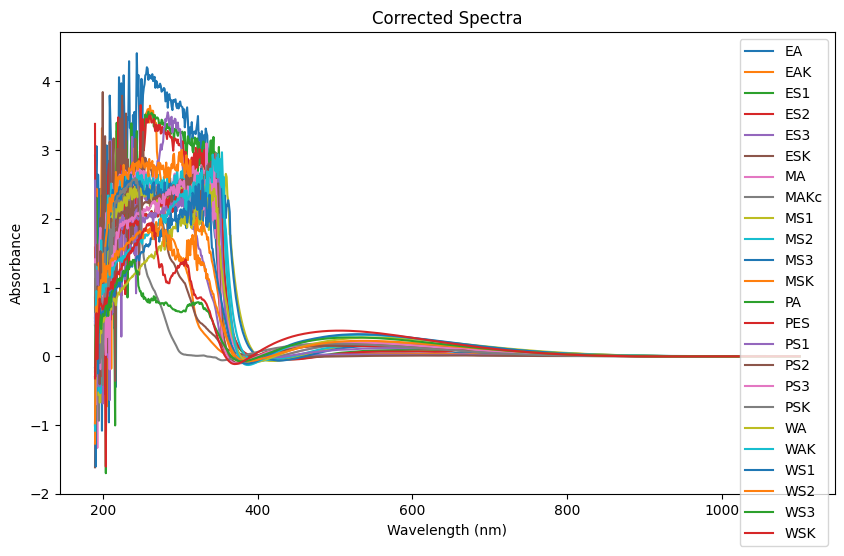

In [ ]:
# Plot the corrected spectra
plt.figure(figsize=(10, 6))
for i in range(corrected_data.shape[0]):
    plt.plot(wavelengths, corrected_data[i, :], label=samples[i])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Corrected Spectra')
plt.legend()
plt.show()

compare

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

1. Polynomial Fitting

In [ ]:
# Example function to perform polynomial baseline correction
def polynomial_baseline_correction(data, degree=3):
    x = np.arange(data.shape[1])
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(x.reshape(-1, 1))
    lin_reg = LinearRegression()
    baselines = []
    for spectrum in data:
        lin_reg.fit(X_poly, spectrum)
        baseline = lin_reg.predict(X_poly)
        baselines.append(baseline)
    return np.array(baselines)

In [ ]:
# Apply polynomial baseline correction
polynomial_baseline = polynomial_baseline_correction(data)
corrected_data_polynomial = data - polynomial_baseline

2. Savitzky-Golay Filter

In [ ]:
from scipy.signal import savgol_filter

# Example function to perform Savitzky-Golay filter baseline correction
def savgol_baseline_correction(data, window_length=11, polyorder=3):
    baselines = savgol_filter(data, window_length, polyorder, axis=1)
    return baselines

# Apply Savitzky-Golay filter baseline correction
savgol_baseline = savgol_baseline_correction(data)
corrected_data_savgol = data - savgol_baseline

3. Whittaker Smoothing

In [ ]:
from scipy.linalg import cho_factor, cho_solve

# Example function to perform Whittaker smoothing baseline correction
def whittaker_smooth(x, w, lambda_, differences=1):
    X = np.array(x)
    m = X.shape[0]
    E = np.eye(m)
    D = np.diff(E, differences).T
    W = np.diag(w)
    A = W + lambda_ * np.dot(D.T, D)
    b = np.dot(W, X)
    cho = cho_factor(A)
    z = cho_solve(cho, b)
    return z

def whittaker_baseline_correction(data, lambda_=1e5, p=0.1):
    baselines = []
    for spectrum in data:
        w = np.ones(len(spectrum))
        w[spectrum < np.percentile(spectrum, p*100)] = p
        baseline = whittaker_smooth(spectrum, w, lambda_)
        baselines.append(baseline)
    return np.array(baselines)

# Apply Whittaker smoothing baseline correction
whittaker_baseline = whittaker_baseline_correction(data)
corrected_data_whittaker = data - whittaker_baseline

4. Spline Fitting

In [ ]:
from scipy.interpolate import UnivariateSpline

# Example function to perform spline fitting baseline correction
def spline_baseline_correction(data, s=1e-5):
    x = np.arange(data.shape[1])
    baselines = []
    for spectrum in data:
        spline = UnivariateSpline(x, spectrum, s=s)
        baseline = spline(x)
        baselines.append(baseline)
    return np.array(baselines)

# Apply spline fitting baseline correction
spline_baseline = spline_baseline_correction(data)
corrected_data_spline = data - spline_baseline

5. Baseline als

In [ ]:
# Plot ALS correction
plot_spectra(wavelengths, data[sample_index], als_baseline[sample_index], corrected_data_als[sample_index], 'ALS Baseline Correction')

Comparison

In [ ]:
# Plotting function
def plot_spectra(wavelengths, original, baseline, corrected, title):
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, original, label='Original Spectrum')
    plt.plot(wavelengths, baseline, label='Baseline', linestyle='--')
    plt.plot(wavelengths, corrected, label='Corrected Spectrum')
    plt.title(title)
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

In [ ]:
# Select a sample index to visualize
sample_index = 0

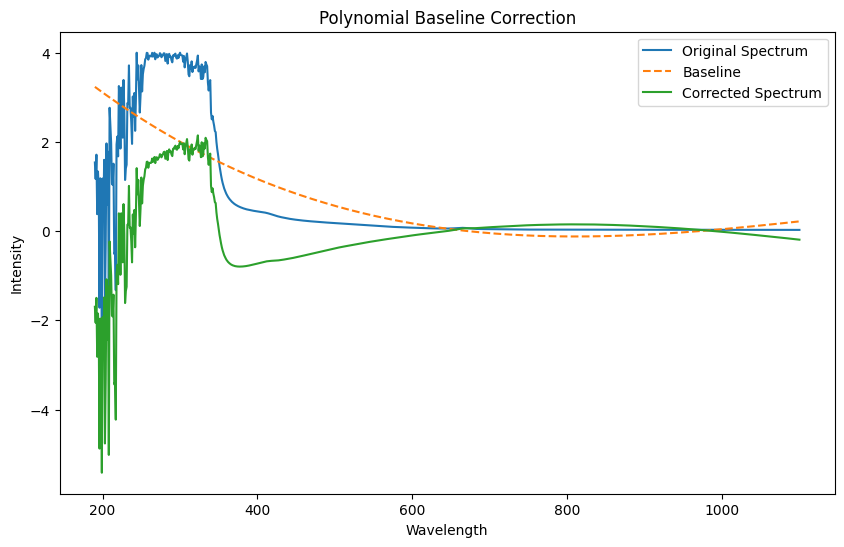

In [ ]:
# Plot polynomial correction
plot_spectra(wavelengths, data[sample_index], polynomial_baseline[sample_index], corrected_data_polynomial[sample_index], 'Polynomial Baseline Correction')

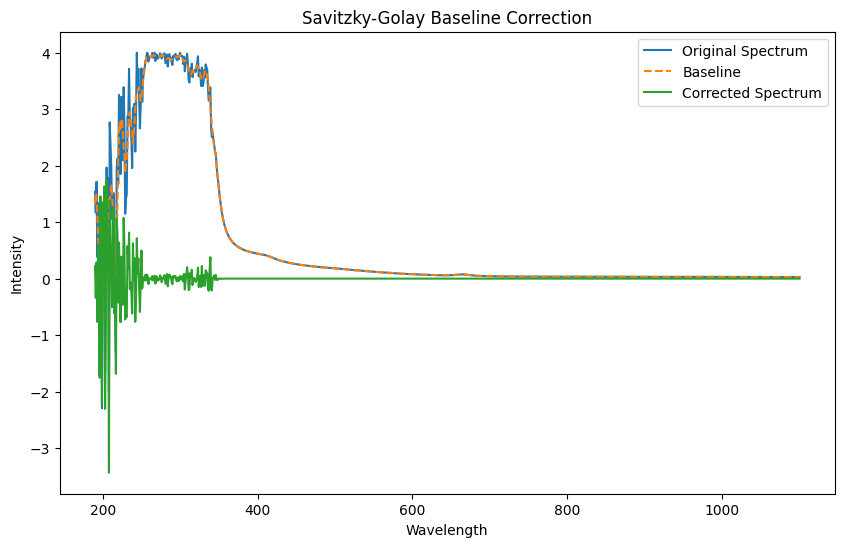

In [ ]:
# Plot Savitzky-Golay correction
plot_spectra(wavelengths, data[sample_index], savgol_baseline[sample_index], corrected_data_savgol[sample_index], 'Savitzky-Golay Baseline Correction')

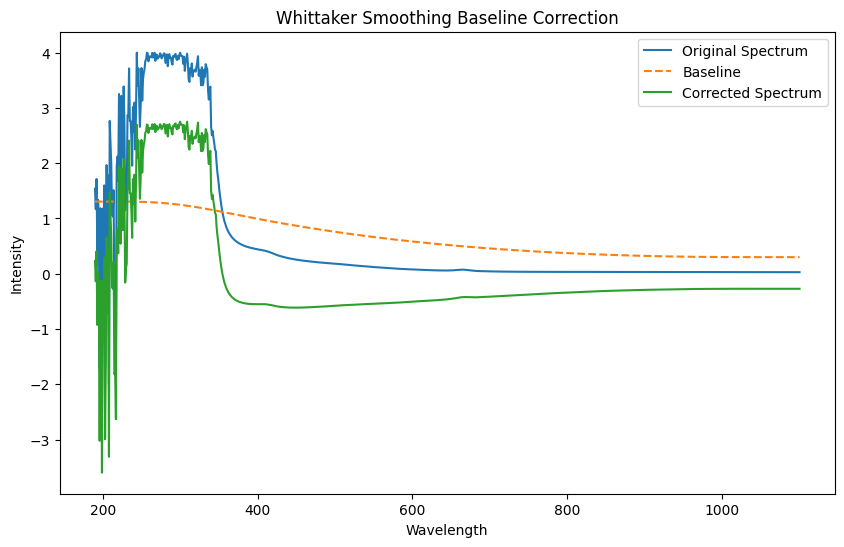

In [ ]:
# Plot Whittaker smoothing correction
plot_spectra(wavelengths, data[sample_index], whittaker_baseline[sample_index], corrected_data_whittaker[sample_index], 'Whittaker Smoothing Baseline Correction')

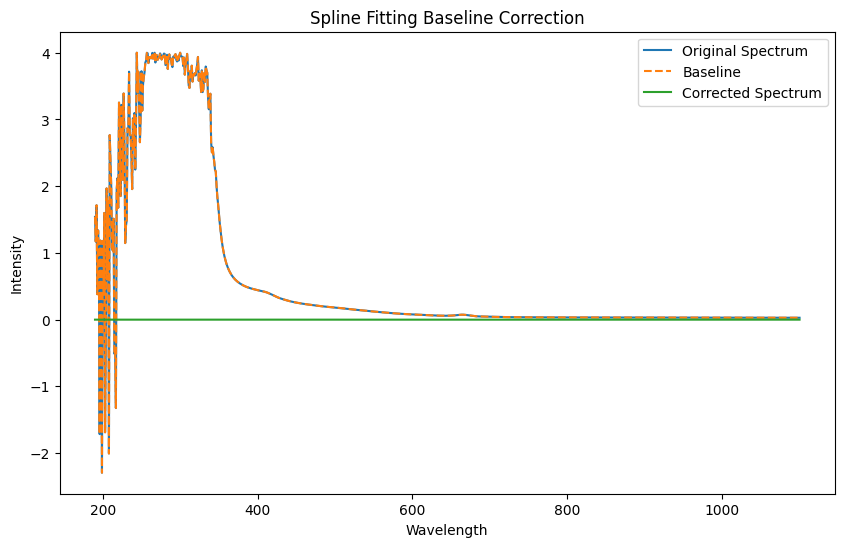

In [ ]:
# Plot spline fitting correction
plot_spectra(wavelengths, data[sample_index], spline_baseline[sample_index], corrected_data_spline[sample_index], 'Spline Fitting Baseline Correction')